# Plot Frontend

Plots statistics and data collected from the frontend related to feature detection,
RANSAC pose recovery, sparse stereo matching and timing.

In [1]:
import yaml
import os
import copy
import pandas as pd
import numpy as np

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

import plotly.graph_objects as go

import evaluation.tools as evt
from evaluation.evaluation_lib import get_ape_trans, get_ape_rot, plot_metric, convert_abs_traj_to_rel_traj

%matplotlib inline
# %matplotlib notebookw_T_bi
import matplotlib.pyplot as plt

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [2]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
vio_output_dir = "/home/jnshi/ford_ws/src/Kimera-VIO-ROS/output_logs/Ford"
gt_data_file = "/home/jnshi/ford_ws/src/Kimera-VIO-ROS/output_logs/Ford/traj_gt.csv"

## Frontend Statistics

Calculate and plot important statistics from the frontend of the VIO module

These statistics include the number of tracked and detected features, data relating the RANSAC runs for both mono 5-point and stereo 3-point methods, timing data and sparse-stereo-matching statistics.

In [3]:
# Parse frontend statistics csv file.
stats_file = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_stats.csv")

# Convert to tidy pandas DataFrame object.
df_stats = pd.read_csv(stats_file, sep=',', index_col=False)
df_stats.head()

,#timestamp_lkf,mono_status,stereo_status,nr_keypoints,nrDetectedFeatures,nrTrackerFeatures,nrMonoInliers,nrMonoPutatives,nrStereoInliers,nrStereoPutatives,...,nrNoRightRectRKP,nrNoDepthRKP,nrFailedArunRKP,featureDetectionTime,featureTrackingTime,monoRansacTime,stereoRansacTime,featureSelectionTime,extracted_corners,need_n_corners
0,3355253999999,LOW_DISPARITY,INVALID,504,0,495,460,495,0,0,...,2,510,0,0,6,2,0,0,0,0
1,3355288000000,LOW_DISPARITY,INVALID,500,0,502,497,502,0,0,...,3,481,0,0,9,0,0,0,0,0
2,3355320999999,LOW_DISPARITY,INVALID,500,0,500,488,500,0,0,...,3,488,0,0,5,0,0,0,0,0
3,3355353999999,LOW_DISPARITY,INVALID,501,0,500,478,500,0,0,...,3,498,0,0,7,1,0,0,0,0
4,3355387000000,LOW_DISPARITY,INVALID,500,0,500,494,500,0,0,...,2,485,0,0,4,0,0,0,0,0


In [4]:
# Helper functions for processing data summary.
def get_mean(attrib):
    ls = df_stats[attrib].tolist()
    return float(sum(ls)) / len(ls)

def get_min(attrib):
    return min(df_stats[attrib])

def get_max(attrib):
    return max(df_stats[attrib])

# Construct and visualize summary. TODO(marcus): use a LaTeX table.
summary_stats = [
    ("Average number of detected features", get_mean("nrDetectedFeatures")),
    ("Minimum number of detected features", get_min("nrDetectedFeatures")),
    ("Average number of tracked features" , get_mean("nrTrackerFeatures")),
    ("Minimum number of tracked features", get_min("nrTrackerFeatures")),
    ("Average number of mono ransac inliers", get_mean("nrMonoInliers")),
    ("Minimum number of mono ransac inliers", get_min("nrMonoInliers")),
    ("Average number of stereo ransac inliers", get_mean("nrStereoInliers")),
    ("Minimum number of stereo ransac inliers", get_min("nrStereoInliers")),
    ("Average number of mono ransac putatives", get_mean("nrMonoPutatives")),
    ("Minimum number of mono ransac putatives", get_min("nrMonoPutatives")),
    ("Average number of stereo ransac putatives", get_mean("nrStereoPutatives")),
    ("Minimum number of stereo ransac putatives", get_min("nrStereoPutatives")),
]

attrib_len = [len(attrib[0]) for attrib in summary_stats]
max_attrib_len = max(attrib_len)

print("\nStatistic summary:\n")
for entry in summary_stats:
    attrib = entry[0]
    value = entry[1]
    spacing = max_attrib_len - len(attrib)
    print(attrib + " "*spacing + ": " + str(value))


Statistic summary:

Average number of detected features      : 0.0
Minimum number of detected features      : 0
Average number of tracked features       : 496.654761905
Minimum number of tracked features       : 467
Average number of mono ransac inliers    : 476.220634921
Minimum number of mono ransac inliers    : 336
Average number of stereo ransac inliers  : 0.0
Minimum number of stereo ransac inliers  : 0
Average number of mono ransac putatives  : 496.654761905
Minimum number of mono ransac putatives  : 467
Average number of stereo ransac putatives: 0.0
Minimum number of stereo ransac putatives: 0


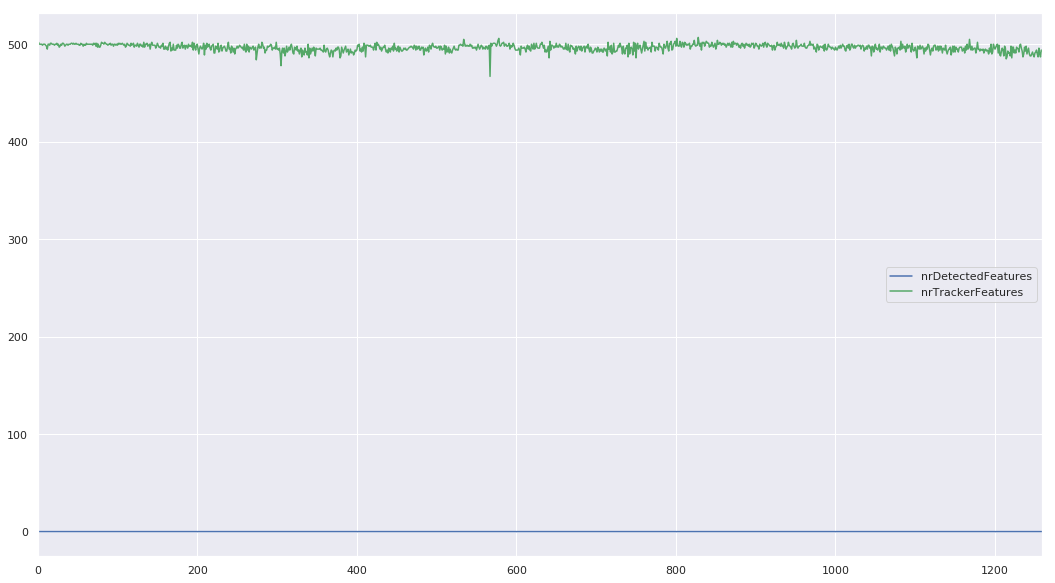

In [5]:
# Plot feature tracking statistics.
use_plotly = False

if not use_plotly:
    fig0, axes0 = plt.subplots(nrows=1, ncols=1, figsize=(18,10), squeeze=False)
    df_stats.plot(kind="line", y="nrDetectedFeatures", ax=axes0[0,0])
    df_stats.plot(kind="line", y="nrTrackerFeatures", ax=axes0[0,0])
    plt.show()
else:
    evt.draw_feature_tracking_stats(df_stats, True)


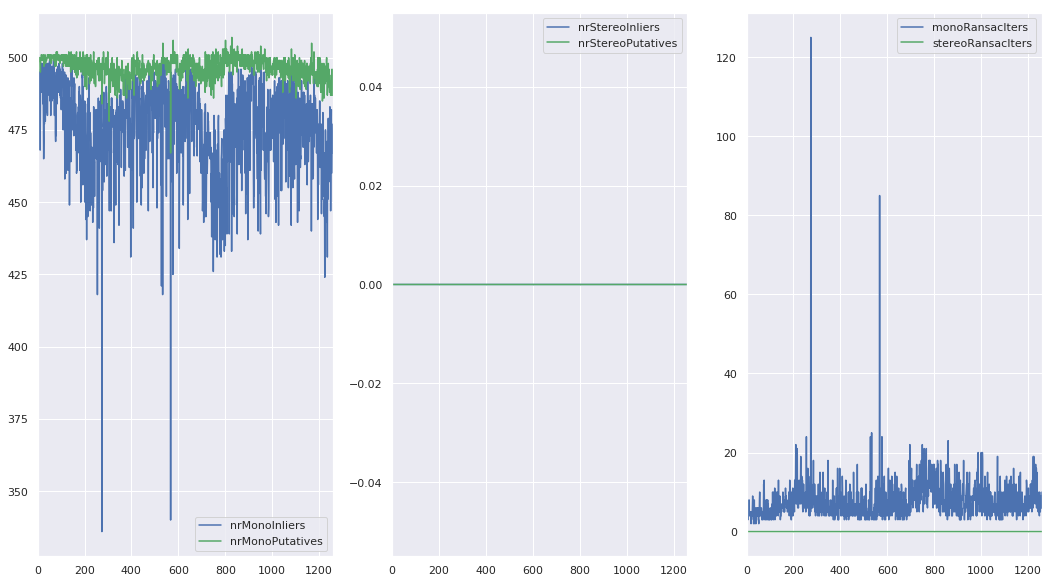

In [6]:
# Plot ransac inlier, putative and iteration statistics.
if not use_plotly:
    fig1, axes1 = plt.subplots(nrows=1, ncols=3, figsize=(18,10), squeeze=False)
    df_stats.plot(kind="line", y="nrMonoInliers", ax=axes1[0,0])
    df_stats.plot(kind="line", y="nrMonoPutatives", ax=axes1[0,0])
    df_stats.plot(kind="line", y="nrStereoInliers", ax=axes1[0,1])
    df_stats.plot(kind="line", y="nrStereoPutatives", ax=axes1[0,1])
    df_stats.plot(kind="line", y="monoRansacIters", ax=axes1[0,2])
    df_stats.plot(kind="line", y="stereoRansacIters", ax=axes1[0,2])
    plt.show()
else:
    evt.draw_mono_stereo_inliers_outliers(df_stats, True)

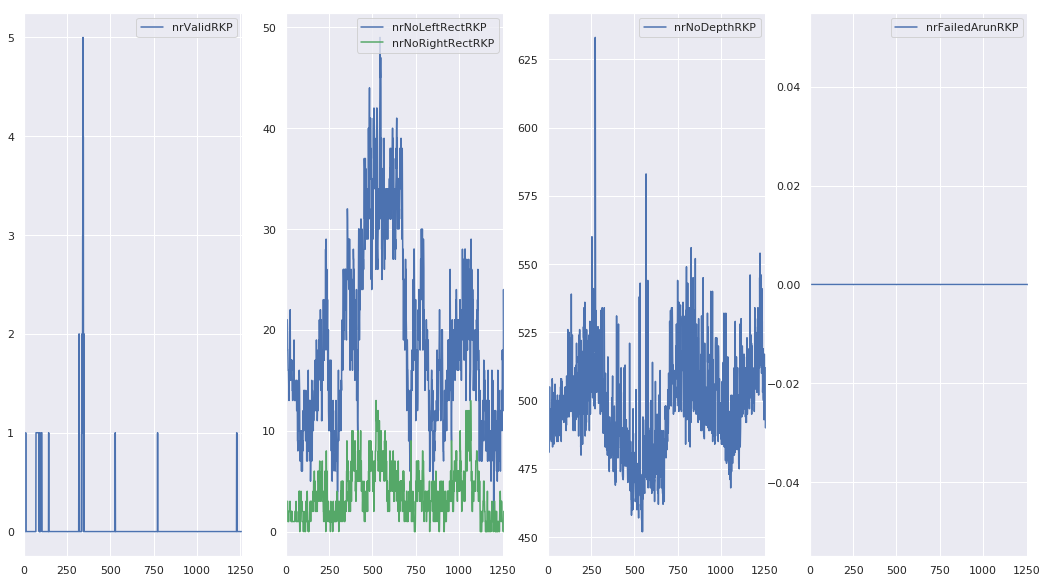

In [7]:
# Plot sparse-stereo-matching statistics.

fig3, axes3 = plt.subplots(nrows=1, ncols=4, figsize=(18,10), squeeze=False)

df_stats.plot(kind="line", y="nrValidRKP", ax=axes3[0,0])
df_stats.plot(kind="line", y="nrNoLeftRectRKP", ax=axes3[0,1])
df_stats.plot(kind="line", y="nrNoRightRectRKP", ax=axes3[0,1])
df_stats.plot(kind="line", y="nrNoDepthRKP", ax=axes3[0,2])
df_stats.plot(kind="line", y="nrFailedArunRKP", ax=axes3[0,3])

plt.show()

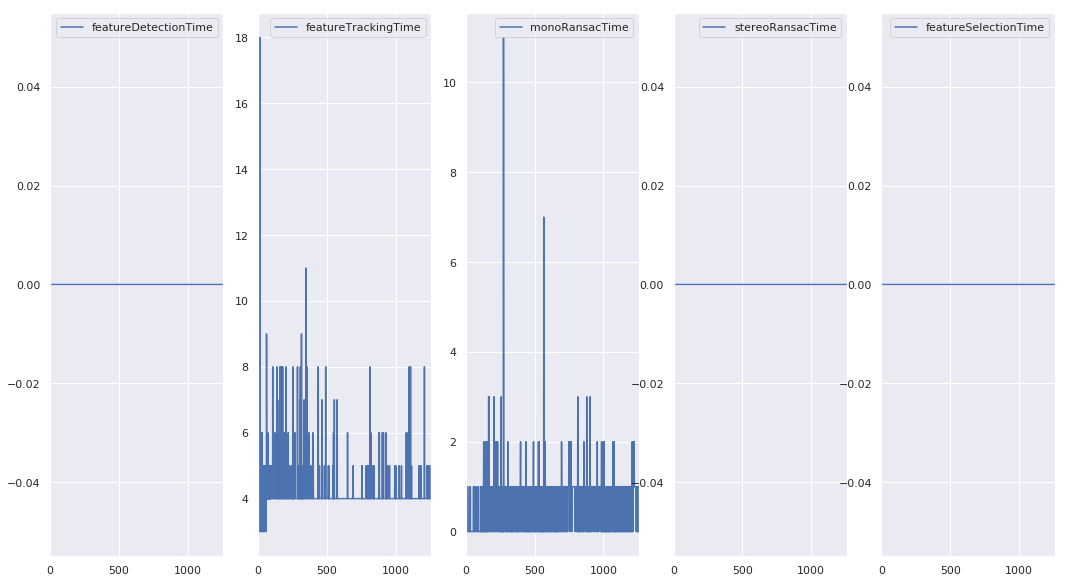

In [8]:
# Plot timing statistics.
if not use_plotly:
    fig2, axes2 = plt.subplots(nrows=1, ncols=5, figsize=(18,10), squeeze=False)
    df_stats.plot(kind="line", y="featureDetectionTime", ax=axes2[0,0])
    df_stats.plot(kind="line", y="featureTrackingTime", ax=axes2[0,1])
    df_stats.plot(kind="line", y="monoRansacTime", ax=axes2[0,2])
    df_stats.plot(kind="line", y="stereoRansacTime", ax=axes2[0,3])
    df_stats.plot(kind="line", y="featureSelectionTime", ax=axes2[0,4])
    plt.show()
else:
    evt.draw_frontend_timing(df_stats, True)

# Frontend Mono Ransac Poses (RPE)

Calculate relative-pose-error (RPE) for the mono ransac poses obtained in the frontend.

These are relative poses between keyframes and do not represent an entire trajectory. As such, they cannot be processed using the normal EVO evaluation pipeline.

We import the csv data as Pandas DataFrame objects and perform our own data association. Relative poses for ground truth data are computed explicitly here. Rotation error and translation error (up to a scaling factor) are then calculated for each pair of consecutive keyframes.

This gives insight into the accuracy of the RANSAC 5-point method employed in the frontend.


NOTE: gt_df is read from the ground-truth csv. It expects the timestamp to be the first column. Make sure to comment out `rename_euroc_gt_df(gt_df)` in the second cell below if you are not using a csv with the EuRoC header.

In [9]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

ransac_mono_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_ransac_mono.csv")
mono_df = pd.read_csv(ransac_mono_filename, sep=',', index_col=0)

In [10]:
gt_df = gt_df[~gt_df.index.duplicated()]

In [11]:
# Convert to evo trajectory objects
traj_ref_unassociated = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
traj_est_unassociated = pandas_bridge.df_to_trajectory(mono_df)

# Associate the trajectories
traj_ref_abs, traj_est_rel = sync.associate_trajectories(traj_ref_unassociated, traj_est_unassociated)

traj_ref_rel = convert_abs_traj_to_rel_traj(traj_ref_abs, up_to_scale=True)

# Remove the first timestamp; we don't have relative pose at first gt timestamp
traj_est_rel = trajectory.PoseTrajectory3D(traj_est_rel._positions_xyz[1:],
                                           traj_est_rel._orientations_quat_wxyz[1:],
                                           traj_est_rel.timestamps[1:])

print "traj_ref_rel: ", traj_ref_rel
print "traj_est_rel: ", traj_est_rel

# Save this relative-pose ground truth file to disk as a csv for later use, if needed.
# gt_rel_filename = "/home/marcus/output_gt_rel_poses_mono.csv"
# gt_rel_df.to_csv(filename, sep=',', columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])

traj_ref_rel:  1250 poses, 10.556m path length, 41.706s duration
traj_est_rel:  1250 poses, 29.807m path length, 41.708s duration


In [12]:
# Get RPE for entire relative trajectory.
ape_rot = get_ape_rot((traj_ref_rel, traj_est_rel))
ape_tran = get_ape_trans((traj_ref_rel, traj_est_rel))

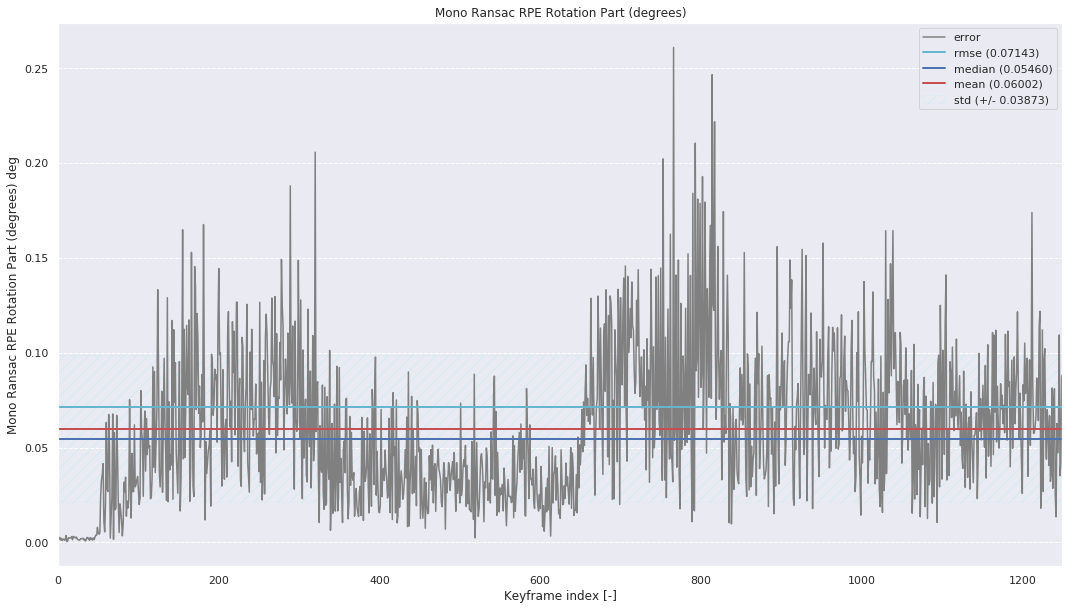

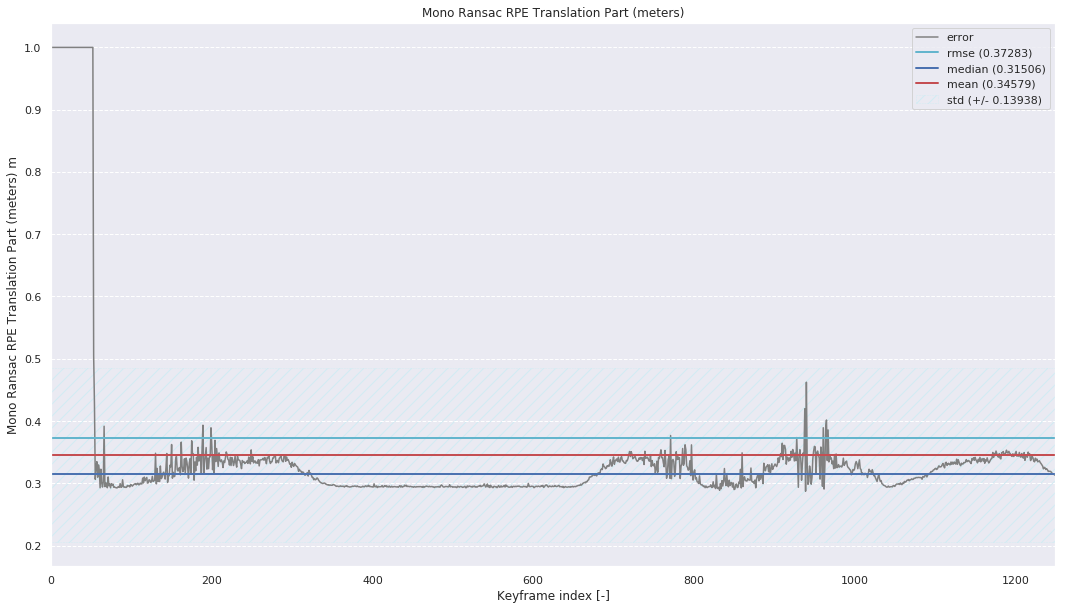

In [13]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est_rel.timestamps[0] for t in traj_est_rel.timestamps]

fig1 = plot_metric(ape_rot, "Mono Ransac RPE Rotation Part (degrees)", figsize=(18,10))
fig2 = plot_metric(ape_tran, "Mono Ransac RPE Translation Part (meters)", figsize=(18,10))
plt.show()

# Frontend Stereo Ransac Poses (RPE)

Calculate relative-pose-error (RPE) for the stereo ransac poses obtained in the frontend.

This is done in the same way as in the mono module.

This gives insight into the accuracy of the RANSAC 3-point method employed in the frontend.

NOTE: gt_df is read from the ground-truth csv. It expects the timestamp to be the first column. Make sure to comment out `rename_euroc_gt_df(gt_df)` in the second cell below if you are not using a csv with the EuRoC header.

In [14]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

ransac_stereo_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_frontend_ransac_stereo.csv")
stereo_df = pd.read_csv(ransac_stereo_filename, sep=',', index_col=0)

In [15]:
gt_df = gt_df[~gt_df.index.duplicated()]

In [16]:
# Convert to evo trajectory objects
traj_ref_unassociated = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
traj_est_unassociated = pandas_bridge.df_to_trajectory(stereo_df)

# Associate the trajectories
traj_ref_abs, traj_est_rel = sync.associate_trajectories(traj_ref_unassociated, traj_est_unassociated)

traj_ref_rel = convert_abs_traj_to_rel_traj(traj_ref_abs)

# Remove the first timestamp; we don't have relative pose at first gt timestamp
traj_est_rel = trajectory.PoseTrajectory3D(traj_est_rel._positions_xyz[1:],
                                           traj_est_rel._orientations_quat_wxyz[1:],
                                           traj_est_rel.timestamps[1:])

print "traj_ref_rel: ", traj_ref_rel
print "traj_est_rel: ", traj_est_rel

# Convert the absolute poses (world frame) of the gt DataFrame to relative poses.

# Save this relative-pose ground truth file to disk as a csv for later use, if needed.
# gt_rel_filename = "/home/marcus/output_gt_rel_poses_stereo.csv"
# gt_rel_df.to_csv(filename, sep=',', columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])

traj_ref_rel:  1250 poses, 15.675m path length, 41.706s duration
traj_est_rel:  1250 poses, 0.000m path length, 41.708s duration


In [17]:
# Get RPE for entire relative trajectory.
rpe_rot = get_ape_rot((traj_ref_rel, traj_est_rel))
rpe_tran = get_ape_trans((traj_ref_rel, traj_est_rel))

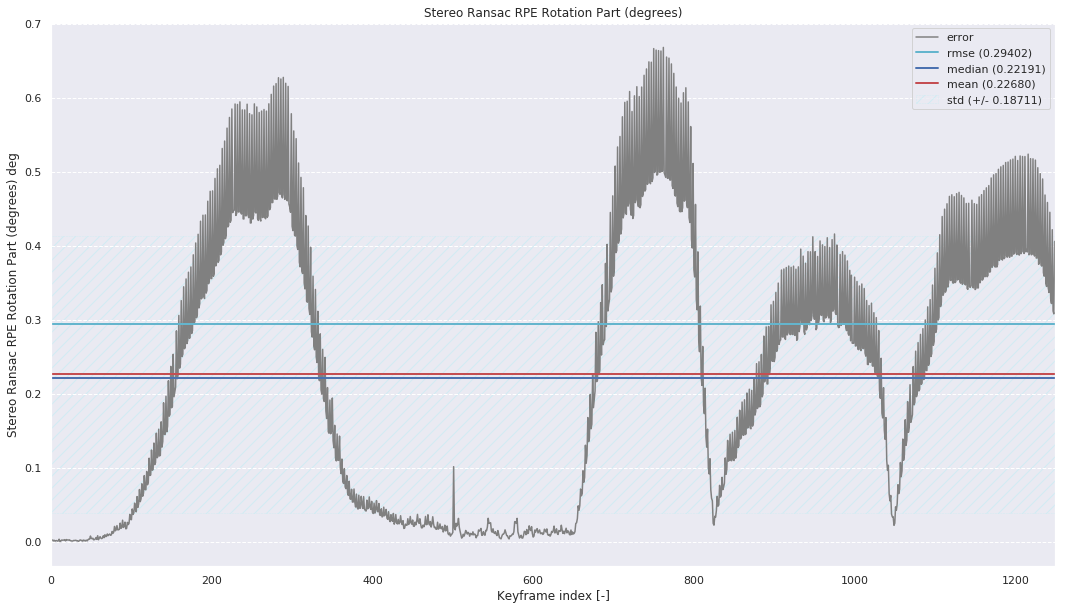

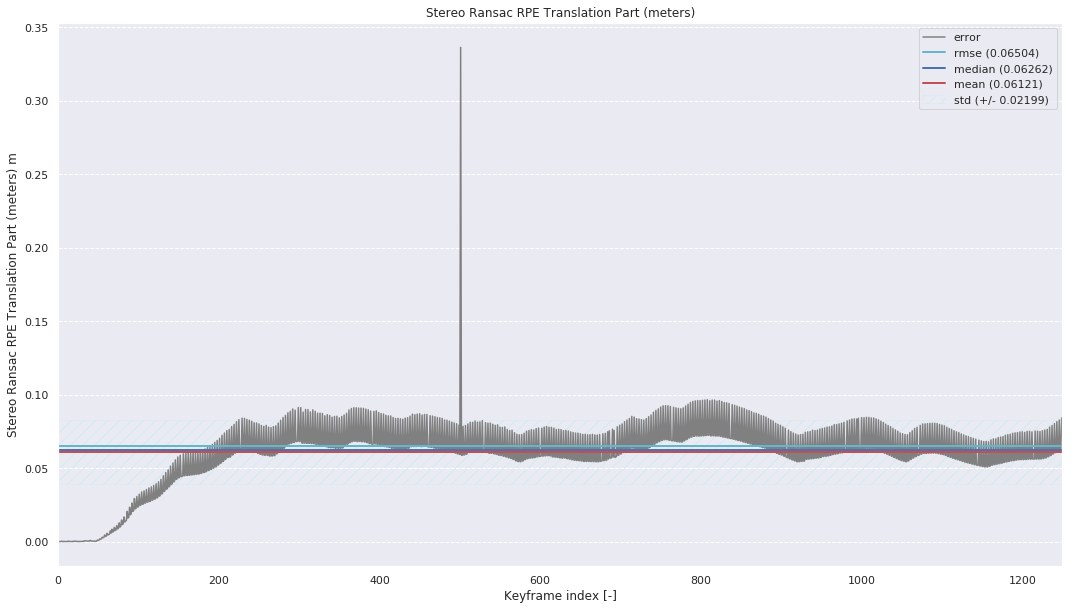

In [18]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est_rel.timestamps[0] for t in traj_est_rel.timestamps]

plot_metric(rpe_rot, "Stereo Ransac RPE Rotation Part (degrees)", figsize=(18,10))
plot_metric(rpe_tran, "Stereo Ransac RPE Translation Part (meters)", figsize=(18,10))
plt.show()